In [1]:
import geopandas as gpd
import numpy as np
import os
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import shapely
import matplotlib.colors

from climada.util import coordinates as u_coords
from climada.hazard import Hazard
from climada_petals.engine.networks.nw_base import Network
from climada_petals.engine.networks.nw_calcs import Graph

import analysis.analysis_funcs as af
import analysis.plotting_funcs as pf

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import sys
import os
import glob
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import climada.util.coordinates as u_coords
import pickle
#from climada_petals.engine.networks import nw_utils as nwu
os.chdir('/cluster/project/climate/evelynm/mplotutils') 
import mplotutils as mpu

## Code

In [17]:
class InfraColorMaps:
    def __init__(self):
        self.service_col_dict = {-1. : '#FF5733', 0. : 'grey', 1. : 'green'}
        self.service_col_map = ListedColormap(['#FF5733', 'grey', 'green'])
        self.servicecum_col_dict = {-9. : '#581845', -8. : '#581845',
                                -7. : '#581845', -6. : '#581845',  
                                -5. : '#581845', -4. : '#581845',
                                -3. : '#900C3F', -2. : '#C70039', 
                                -1. : '#FF5733', 0. : 'grey', 
                                 1. : 'green'}
        self.servicecum_col_map = ListedColormap(['#581845',  '#581845',
                                '#581845',  '#581845',  '#581845', '#581845',
                               '#900C3F', '#C70039',  '#FF5733', 'grey', 'green'])
        self.casc_col_dict = {0. : 'blue', 1. : 'magenta', 2. : 'yellow'}
        self.casc_col_map = ListedColormap(['blue','magenta','yellow'])

def _two_slope_norm(vmin=-10, vcenter=0, vmax=1):
    """
    Two Slope Norm example from
    https://matplotlib.org/stable/tutorials/colors/colormapnorms.html
    """
    #cols_access = plt.cm.Greens(np.linspace(0.75, 1, 25))
    cols_access = plt.cm.Greens(np.linspace(0.2, 0.3, 10))
    cols_inavail = plt.cm.Greys(np.linspace(0.2, 0.3, 11))
    cols_disrupt = plt.cm.magma(np.linspace(0, 0.75, 20))
    all_colors = np.vstack((cols_disrupt, cols_inavail, cols_access))
    segment_colmap = colors.LinearSegmentedColormap.from_list('service_states', all_colors)
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    return segment_colmap, divnorm      
        


In [18]:
def _get_extent(gdf):
    buffer_deg = 0.1
    sub_gdf = gdf[gdf.geometry.type == 'Point']
    return (min(sub_gdf.geometry.x)-buffer_deg, max(sub_gdf.geometry.x)+buffer_deg,
                     min(sub_gdf.geometry.y)-buffer_deg, max(sub_gdf.geometry.y)+buffer_deg)

def _get_roadmask(gdf):
    """
    don't plot road access links which were generated during network construction
    in road plots
    """
    access_links = 0
    for ci_type in ['health', 'education', 'people']:
        access_links+=sum(gdf.ci_type==ci_type)
    return sum(gdf.ci_type=='road')-int(access_links*2)


In [19]:
def infra_impact_plot(gdf, ci_type, save_path=None, event_name=None):
    """ 
    per infrastructure, a plot of structural damages
    """
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    f, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(8,8))
    
    ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
    ax.add_feature(border, facecolor='none', edgecolor='0.5')
    ax.axis('off')
    
    if ci_type=='power_line':
        h_imp = gdf[gdf.ci_type==ci_type].plot('imp_dir', ax=ax, markersize=3, linewidth=1.5, 
                                           transform=ccrs.PlateCarree(), vmin=0.,
                                           vmax=9000, legend=True,
                                            legend_kwds={"location":"bottom",
                                                         "shrink":.5,
                                                         "label":'damaged lines (metres)',
                                                         "pad":-0.},)
        gdf[gdf.ci_type=='power_plant'].plot('imp_dir', ax=ax, markersize=40, linewidth=0.5, 
                                             transform=ccrs.PlateCarree(), vmin=0., vmax=1.)
     
    else:
        h_imp = ax.scatter(gdf[gdf.ci_type==ci_type].geometry.x, 
                           gdf[gdf.ci_type==ci_type].geometry.y, 
                        c=gdf[gdf.ci_type==ci_type].imp_dir,
                        transform=ccrs.PlateCarree(), s=1.5, vmin=0., vmax=1.)
    #ax.set_title(f'Structural damage to {service_dict()[ci_type]} infrastructure', 
                  #   weight='bold', fontsize=17)
    
    #cbar = mpu.colorbar(h_imp, ax.flatten(), size=0.05, pad=0.15, 
                       # orientation='horizontal')
    #cbar.set_label('Structural Damage Frac.')

    f.tight_layout()                                    
    if save_path:
        plt.savefig(f'{save_path}'+f'structural_impacts_{event_name}.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [20]:
def infra_func_plot(gdf, ci_type, save_path=None, event_name=None):
    """ 
    per infrastructure, a plot of functional, destroyed-dysfunctional, 
    cascaded-dysfunctional
    """
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    f, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(8,8))
    
    ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
    ax.add_feature(border, facecolor='none', edgecolor='0.5')
    ax.axis('off')
    
    if ci_type=='power_line':
        h_casc = gdf[gdf.ci_type=='power_line'].plot(ax=ax, markersize=1, linewidth=1.5, 
                                                    transform=ccrs.PlateCarree(), 
                                                    color=gdf[(gdf.ci_type=='power_line')].casc_state.map(
                                               InfraColorMaps().casc_col_dict).values.tolist(),
                                            legend=True,
                                            legend_kwds={"location":"bottom",
                                                         "shrink":.5,
                                                         "label":'functional state',
                                                         "pad":-0.},)
        
        
        h_casc= ax.scatter(gdf[gdf.ci_type=='power_plant'].geometry.x, 
                            gdf[gdf.ci_type=='power_plant'].geometry.y, 
                            c=gdf[gdf.ci_type=='power_plant']['casc_state'],
                            cmap=InfraColorMaps().casc_col_map, 
                            transform=ccrs.PlateCarree(), 
                            vmin=0., vmax=2., s=30)
        
        """  gdf[gdf.ci_type=='power_plant'].plot(ax=ax, markersize=30, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), 
                           color=gdf[gdf.ci_type=='power_plant'].casc_state.map(
                               InfraColorMaps().casc_col_dict).values.tolist(),
                                            legend=True,
                                            legend_kwds={"location":"bottom",
                                                         "shrink":.5,
                                                         "label":'functional state',
                                                         "pad":-0.},)"""
    cbar = mpu.colorbar(
        h_casc, ax, size=0.05, pad=0.05, orientation='horizontal')
    cbar.set_ticks([0.33, 1., 1.66])
    cbar.set_ticklabels(['Func.', 'Dysfunc.', 'Casc.'])    
    f.tight_layout()
    
    if save_path:
        plt.savefig(f'{save_path}'+f'failure_states_{event_name}.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [21]:
        
def service_impact_plot(gdf, service, save_path=None, event_name=None):
    """
    per basic service, people cluster with and without access to that service
    """
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    f, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(8,8))
    
    ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
    ax.add_feature(border, facecolor='none', edgecolor='0.5')
    ax.axis('off')

    h_serv = ax.scatter(gdf[gdf.ci_type=='people'].geometry.x, 
                            gdf[gdf.ci_type=='people'].geometry.y, 
                            c=gdf[gdf.ci_type=='people'][service],
                            cmap=InfraColorMaps().service_col_map, 
                            transform=ccrs.PlateCarree(), 
                            vmin=-1., vmax=1., s=0.2)
           
    cbar = mpu.colorbar(
        h_serv, ax, size=0.05, pad=0.05, orientation='horizontal')
    cbar.set_ticks([-0.66, 0., .66])
    cbar.set_ticklabels(['Disr.', 'Inavail.', 'Avail.'])

  
    #f.suptitle(f'Service Disruptions from event {event_name}', weight='bold', fontsize=24)
    f.subplots_adjust(bottom=0.05, top=0.95)  
    f.tight_layout()                                
    if save_path:
        plt.savefig(f'{save_path}'+f'service_disruptions_{event_name}.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [22]:
def service_dict():
    return {'power_line' : 'power',
           'celltower' : 'telecom',
           'health': 'healthcare facilities',
           'education' : 'educational facility',
           'road' : 'roads'}

## Examples

### Load result data - Hainan (CHN)

In [8]:
    # Variable definitions
    cntry = 'China'
    state = 'Hainan'
    haz_type = 'TC'
    iso3 = u_coords.country_to_iso(cntry)

    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_state_folder = path_cntry_folder+f'{state}/'
    path_save_plots = path_state_folder+'plots/'
    path_nodes = path_state_folder+'cis_nw_nodes'
    path_edges = path_state_folder+'cis_nw_edges'
    path_event_stats = path_state_folder+f'service_stats_{haz_type}_{iso3}_{state}.pkl'
    path_base_stats = path_state_folder+f'base_stats_{iso3}_{state}.pkl'
    path_disr_stats = path_state_folder+f'disruption_rates_{iso3}_{state}_{haz_type}.pkl'
    path_dest_stats = path_state_folder+f'destruction_rates_{iso3}_{state}_{haz_type}.pkl'

In [10]:
    gdf_nodes_orig = gpd.read_feather(path_nodes)
    gdf_edges_orig = gpd.read_feather(path_edges)
    ci_network = Network(edges=gdf_edges_orig, 
                         nodes=gdf_nodes_orig)
    ci_graph = Graph(ci_network, directed=True)

In [5]:
    base_stat_dict = af.load_dict(path_base_stats)
    base_stat_dict['people'] = 0
    event_stat_dict = af.load_dict(path_event_stats)
    disr_stat_dict = af.load_dict(path_disr_stats)
    dest_stat_dict = af.load_dict(path_dest_stats)

### Define events to analyse

In [6]:
lower_disr_event = '1983186N04153' # "below line"
higher_disr_event = '1995233N16115'# "above line"

In [7]:
gdf_lower_event = gpd.read_feather(path_state_folder+f'cascade_results_{lower_disr_event}')
gdf_higher_event = gpd.read_feather(path_state_folder+f'cascade_results_{higher_disr_event}')

In [33]:
df_stats_lower = pd.DataFrame.from_dict(disr_stat_dict[lower_disr_event], orient='index').rename({0:lower_disr_event}, axis=1)
df_stats_higher = pd.DataFrame.from_dict(disr_stat_dict[higher_disr_event], orient='index').rename({0:higher_disr_event}, axis=1)

In [34]:
df_stats = pd.concat([df_stats_lower, df_stats_higher], axis=1)
df_stats = df_stats.reset_index().rename({'index':'service'}, axis=1)
df_stats

In [43]:
df_stats_long = pd.melt(df_stats, id_vars=['service'], value_vars=[lower_disr_event, higher_disr_event], var_name='event_id', value_name='disr_rate')

In [48]:
df_stats_long

,service,event_id,disr_rate
0,power,1983186N04153,0.539163
1,healthcare,1983186N04153,0.572178
2,education,1983186N04153,0.549311
3,telecom,1983186N04153,0.525586
4,mobility,1983186N04153,0.140364
5,people,1983186N04153,0.492178
6,power,1995233N16115,0.934450
7,healthcare,1995233N16115,1.000000
8,education,1995233N16115,0.929752
9,telecom,1995233N16115,0.927254


In [47]:
dir_affected

,service,event_id,disr_rate
5,people,1983186N04153,0.492178
11,people,1995233N16115,0.128045


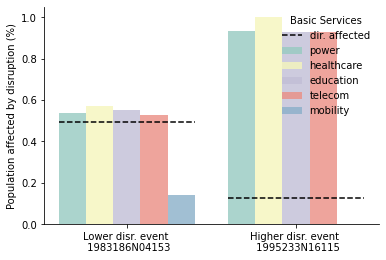

In [54]:
import matplotlib.pyplot as plt

# code for annotated barplot
dir_affected = df_stats_long[df_stats_long.service=='people']

fig, ax = plt.subplots(1,1)
g = sns.barplot(
    data=df_stats_long[df_stats_long.service!='people'],
    x="event_id", y='disr_rate', hue='service',  palette="Set3", alpha=.8, ax=ax)
g.set_xticklabels([f'Lower disr. event \n {lower_disr_event}', 
                   f'Higher disr. event \n {higher_disr_event}'])
#g.despine(left=True)    
plt.ylabel("Population affected by disruption (%)")
plt.xlabel("")
plt.hlines(dir_affected[dir_affected.event_id==lower_disr_event].disr_rate,-0.4,0.4,'k', '--', label='dir. affected')
plt.hlines(dir_affected[dir_affected.event_id==higher_disr_event].disr_rate,0.6,1.4,'k', '--', )

plt.legend(frameon=False, title="Basic Services")
sns.despine()
#plt.savefig(path_save_plots+'multihaz_multiimp_base.png')
#(y, xmin, xmax, colors, linestyles)

In [21]:
print(disr_stat_dict[lower_disr_event])
print(disr_stat_dict[higher_disr_event])

{'power': 0.5391627478707985, 'healthcare': 0.5721776822279959, 'education': 0.5493105582880476, 'telecom': 0.5255856314513997, 'mobility': 0.1403640995347527, 'people': 0.492178447897391}
{'power': 0.9344500692897257, 'healthcare': 1.0, 'education': 0.92975216276613, 'telecom': 0.9272539879851237, 'mobility': 0.0025730402492765833, 'people': 0.12804473986947118}


In [22]:
print(dest_stat_dict[lower_disr_event])
print(dest_stat_dict[higher_disr_event])

{'power_line': 17.6, 'health': 0.0, 'education': 14.4, 'celltower': 20.2, 'road': 3.3, 'people': 49.2}
{'power_line': 5.4, 'health': 0.0, 'education': 0.0, 'celltower': 0.0, 'road': 0.1, 'people': 12.8}


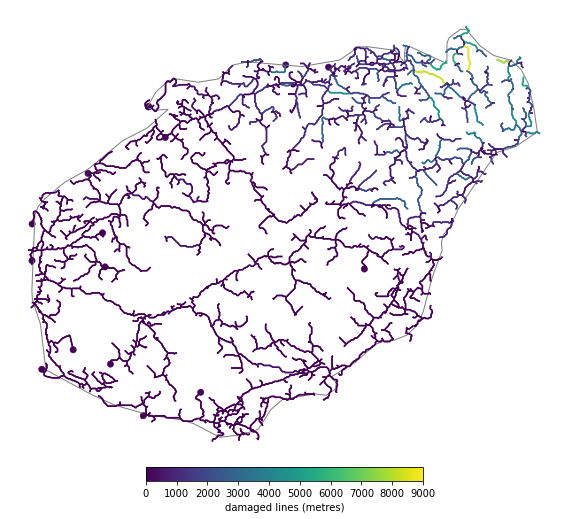

In [124]:
infra_impact_plot(gdf_lower_event, ci_type='power_line', save_path=None, event_name=lower_disr_event)

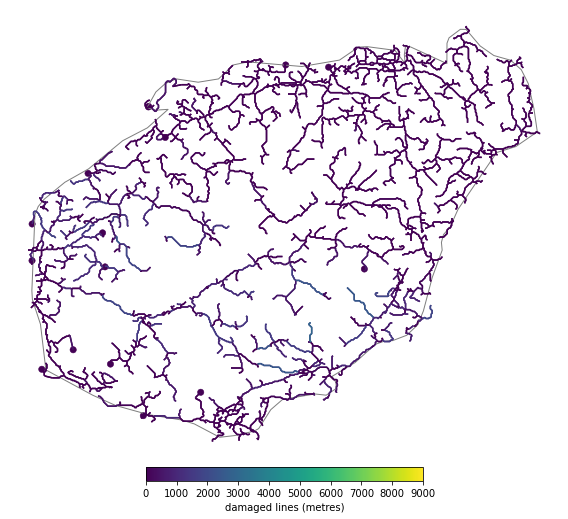

In [125]:
infra_impact_plot(gdf_higher_event, ci_type='power_line', save_path=None, event_name=lower_disr_event)

/scratch/tmp.19032470.evelynm/ipykernel_80046/3070338228.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


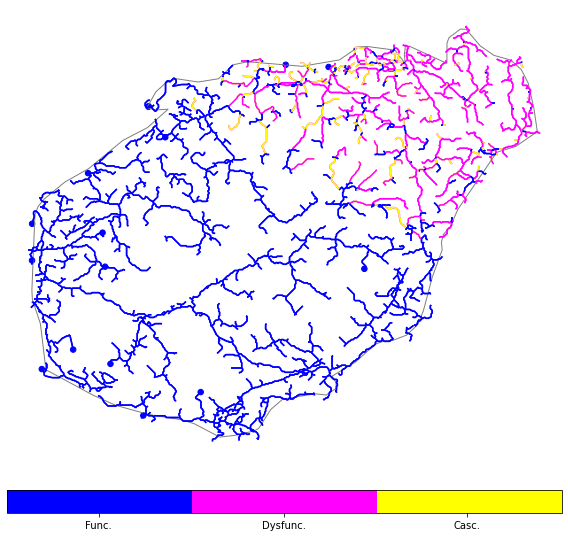

In [162]:
infra_func_plot(gdf_lower_event, ci_type='power_line', save_path=None, event_name=None)

/scratch/tmp.19032470.evelynm/ipykernel_80046/3070338228.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


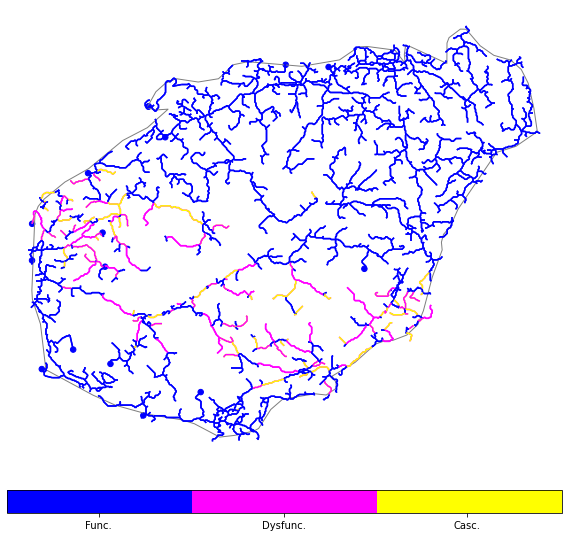

In [163]:
infra_func_plot(gdf_higher_event, ci_type='power_line', save_path=None, event_name=None)

/scratch/tmp.19032470.evelynm/ipykernel_80046/4169882256.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


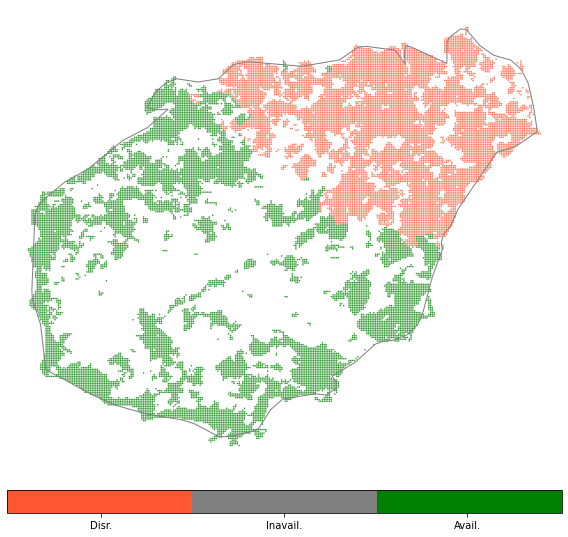

In [147]:
service_impact_plot(gdf_lower_event, service='actual_supply_power_line_people')

/scratch/tmp.19032470.evelynm/ipykernel_80046/4169882256.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


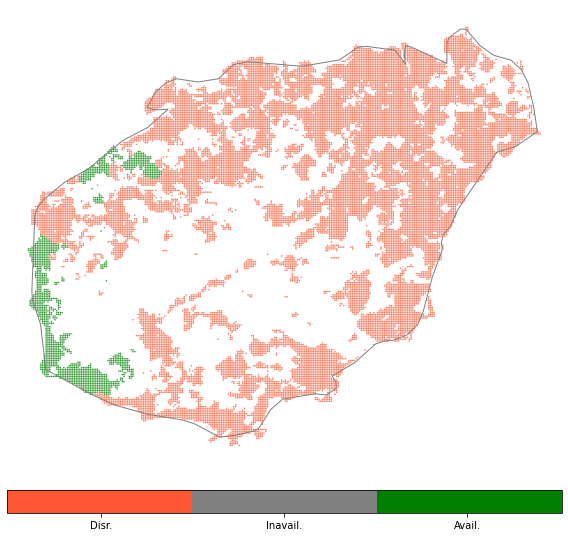

In [152]:
service_impact_plot(gdf_higher_event, service='actual_supply_power_line_people')

In [166]:
lower_disr_event

'1983186N04153'

### Load result data (Mozambique)
    

In [36]:
    cntry = 'Mozambique'
    haz_type = 'TC'
    iso3 = u_coords.country_to_iso(cntry)

    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_save_plots = path_cntry_folder+'plots/'
    path_nodes = path_cntry_folder+'cis_nw_nodes'
    path_event_stats = path_cntry_folder+f'service_stats_{haz_type}_{iso3}.pkl'
    path_base_stats = path_cntry_folder+f'base_stats_{iso3}.pkl'
    path_disr_stats = path_cntry_folder+f'disruption_rates_{iso3}_{haz_type}.pkl'
    path_dest_stats = path_cntry_folder+f'destruction_rates_{iso3}_{haz_type}.pkl'
    path_casc_factor = path_cntry_folder+'perevent_factor_c_MOZ_TC.csv'

In [37]:
    df_casc_factors = pd.read_csv(path_casc_factor, index_col=0)
    gdf_nodes_orig = gpd.read_feather(path_nodes)
    base_stat_dict = af.load_dict(path_base_stats)
    base_stat_dict['people'] = 0
    event_stat_dict = af.load_dict(path_event_stats)
    disr_stat_dict = af.load_dict(path_disr_stats)
    dest_stat_dict = af.load_dict(path_dest_stats)

In [38]:
df_casc_factors

,2007043S11071,2019063S18038,1984016S15073,1982075S12055,2019112S10053,1988055S10051,1982030S15065,2003056S21042,2017043S19040,1981351S12060,1994076S14078,2008062S10064,2000083S17102,2000032S11116,median
electricity,61.640000,4.590000,20.740000,64.960000,3.550000,9.650000,inf,34.430000,18.370000,8.010000,1.890000,1.520000,3.340000,9.660000,9.655000
mobile communications,26.960000,3.890000,15.990000,287.580000,46.790000,10.240000,0.000000,17.490000,11.190000,9.710000,2.090000,1.020000,12.240000,8.450000,10.715000
healthcare,24.460000,3.500000,18.160000,35.620000,4.120000,10.220000,2.290000,15.640000,10.420000,8.070000,2.600000,1.040000,2.380000,5.850000,6.960000
education,27.320000,3.580000,17.960000,33.920000,3.990000,10.450000,10.020000,17.390000,10.920000,7.860000,2.590000,2.750000,7.660000,6.750000,8.940000
mobility,0.460000,0.340000,0.000000,0.490000,0.690000,0.590000,0.200000,0.320000,0.360000,0.160000,0.170000,0.430000,0.320000,0.260000,0.330000
population,0.012742,0.070058,0.009943,0.017084,0.004554,0.041878,0.003468,0.018169,0.020151,0.064984,0.133275,0.019847,0.024768,0.043793,0.019999


In [40]:
example_case1 = '1982075S12055'
example_case2 = '2019063S18038'

In [41]:
gdf_lower_event = gpd.read_feather(path_cntry_folder+f'cascade_results_{example_case2}') # lower casc
gdf_higher_event = gpd.read_feather(path_cntry_folder+f'cascade_results_{example_case1}') # higher casc

<AxesSubplot: >

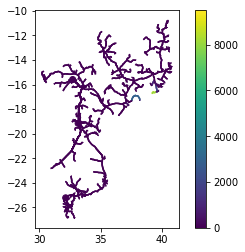

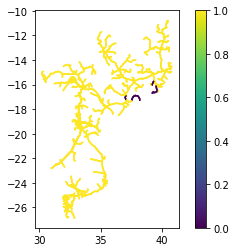

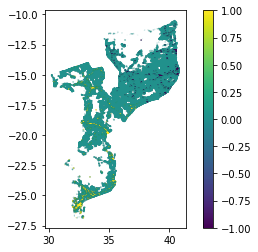

In [47]:
gdf_higher_event[((gdf_higher_event.ci_type=='power_line') |
                 (gdf_higher_event.ci_type=='power_plant'))].plot('imp_dir', legend=True)
gdf_higher_event[((gdf_higher_event.ci_type=='power_line') |
                 (gdf_higher_event.ci_type=='power_plant'))].plot('func_tot', legend=True)
markersize = gdf_higher_event[gdf_higher_event.ci_type=='people'].counts/np.nanmax(gdf_higher_event.counts)
gdf_higher_event[gdf_higher_event.ci_type=='people'].plot('actual_supply_power_line_people', markersize=markersize, legend=True)

<AxesSubplot: >

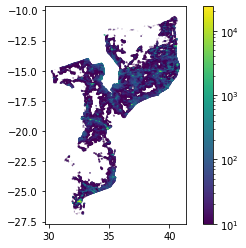

In [55]:
gdf_higher_event[gdf_higher_event.ci_type=='people'].plot('counts', markersize=markersize, legend=True,
                                                         norm=matplotlib.colors.LogNorm(vmin=10, vmax=24000))

<AxesSubplot: >

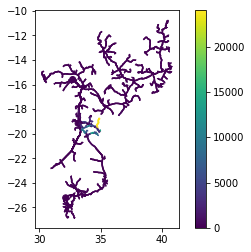

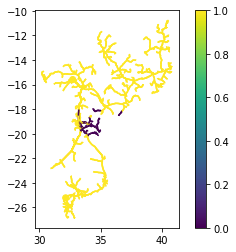

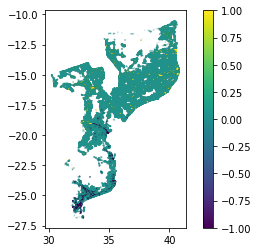

In [56]:
gdf_lower_event[((gdf_lower_event.ci_type=='power_line') |
                 (gdf_lower_event.ci_type=='power_plant'))].plot('imp_dir', legend=True)
gdf_lower_event[((gdf_lower_event.ci_type=='power_line') |
                 (gdf_lower_event.ci_type=='power_plant'))].plot('func_tot', legend=True)
markersize = gdf_lower_event[gdf_lower_event.ci_type=='people'].counts/np.nanmax(gdf_lower_event.counts)
gdf_lower_event[gdf_lower_event.ci_type=='people'].plot('actual_supply_power_line_people', markersize=markersize, legend=True)


## Load result data (Florida)

In [3]:
    # Variable definitions
    cntry = 'USA'
    state = 'Florida'
    haz_type = 'TC'
    iso3 = u_coords.country_to_iso(cntry)

    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_state_folder = path_cntry_folder+f'{state}/'
    path_save_plots = path_state_folder+'plots/'
    path_nodes = path_state_folder+'cis_nw_nodes'
    path_edges = path_state_folder+'cis_nw_edges'
    path_event_stats = path_state_folder+f'service_stats_{haz_type}_{iso3}_{state}.pkl'
    path_base_stats = path_state_folder+f'base_stats_{iso3}_{state}.pkl'
    path_disr_stats = path_state_folder+f'disruption_rates_{iso3}_{state}_{haz_type}.pkl'
    path_dest_stats = path_state_folder+f'destruction_rates_{iso3}_{state}_{haz_type}.pkl'

In [4]:
    gdf_nodes_orig = gpd.read_feather(path_nodes)
    gdf_edges_orig = gpd.read_feather(path_edges)
    ci_network = Network(edges=gdf_edges_orig, 
                         nodes=gdf_nodes_orig)
    ci_graph = Graph(ci_network, directed=True)

In [5]:
    base_stat_dict = af.load_dict(path_base_stats)
    base_stat_dict['people'] = 0
    event_stat_dict = af.load_dict(path_event_stats)
    disr_stat_dict = af.load_dict(path_disr_stats)
    dest_stat_dict = af.load_dict(path_dest_stats)

### Define events to analyse

In [6]:
lower_disr_event = '1998295N12284'
higher_disr_event = '2004223N11301'

In [7]:
gdf_lower_event = gpd.read_feather(path_state_folder+f'cascade_results_{lower_disr_event}')
gdf_higher_event = gpd.read_feather(path_state_folder+f'cascade_results_{higher_disr_event}')

In [8]:
df_stats_lower = pd.DataFrame.from_dict(disr_stat_dict[lower_disr_event], orient='index').rename({0:lower_disr_event}, axis=1)
df_stats_higher = pd.DataFrame.from_dict(disr_stat_dict[higher_disr_event], orient='index').rename({0:higher_disr_event}, axis=1)

In [9]:
df_stats = pd.concat([df_stats_lower, df_stats_higher], axis=1)
df_stats = df_stats.reset_index().rename({'index':'service'}, axis=1)
df_stats

,service,1998295N12284,2004223N11301
0,power,0.122149,0.816925
1,healthcare,0.061149,0.451804
2,education,0.119566,0.814528
3,telecom,0.087075,0.794184
4,mobility,0.031597,0.300565
5,people,0.177694,0.539976


In [10]:
df_stats_long = pd.melt(df_stats, id_vars=['service'], value_vars=[lower_disr_event, higher_disr_event], var_name='event_id', value_name='disr_rate')

In [11]:
df_stats_long

,service,event_id,disr_rate
0,power,1998295N12284,0.122149
1,healthcare,1998295N12284,0.061149
2,education,1998295N12284,0.119566
3,telecom,1998295N12284,0.087075
4,mobility,1998295N12284,0.031597
5,people,1998295N12284,0.177694
6,power,2004223N11301,0.816925
7,healthcare,2004223N11301,0.451804
8,education,2004223N11301,0.814528
9,telecom,2004223N11301,0.794184


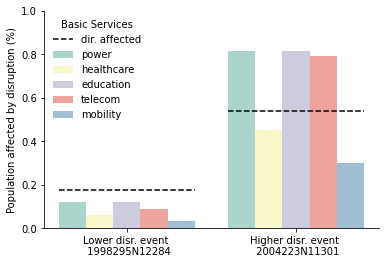

In [31]:
import matplotlib.pyplot as plt

# code for annotated barplot
dir_affected = df_stats_long[df_stats_long.service=='people']

fig, ax = plt.subplots(1,1)
g = sns.barplot(
    data=df_stats_long[df_stats_long.service!='people'],
    x="event_id", y='disr_rate', hue='service',  palette="Set3", alpha=.8, ax=ax)
g.set_xticklabels([f'Lower disr. event \n {lower_disr_event}', 
                   f'Higher disr. event \n {higher_disr_event}'])
plt.ylim([0,1])

#g.despine(left=True)    
plt.ylabel("Population affected by disruption (%)")
plt.xlabel("")
plt.hlines(dir_affected[dir_affected.event_id==lower_disr_event].disr_rate,-0.4,0.4,'k', '--', label='dir. affected')
plt.hlines(dir_affected[dir_affected.event_id==higher_disr_event].disr_rate,0.6,1.4,'k', '--', )

plt.legend(frameon=False, title="Basic Services")
sns.despine()
#plt.savefig(path_save_plots+'multihaz_multiimp_base.png')
#(y, xmin, xmax, colors, linestyles)

In [14]:
print(disr_stat_dict[lower_disr_event])
print(disr_stat_dict[higher_disr_event])

{'power': 0.12214850162207298, 'healthcare': 0.06114859124486222, 'education': 0.11956616302874476, 'telecom': 0.08707522930716613, 'mobility': 0.031596708834708186, 'people': 0.17769443262027337}
{'power': 0.8169248831368537, 'healthcare': 0.4518043913288983, 'education': 0.8145280588089725, 'telecom': 0.7941843700189855, 'mobility': 0.30056541634433864, 'people': 0.539975836381899}


In [15]:
print(dest_stat_dict[lower_disr_event])
print(dest_stat_dict[higher_disr_event])

{'power_line': 3.1, 'health': 0.0, 'education': 2.7, 'celltower': 3.8, 'road': 1.0, 'people': 17.8}
{'power_line': 32.3, 'health': 16.6, 'education': 30.4, 'celltower': 37.9, 'road': 15.6, 'people': 54.0}


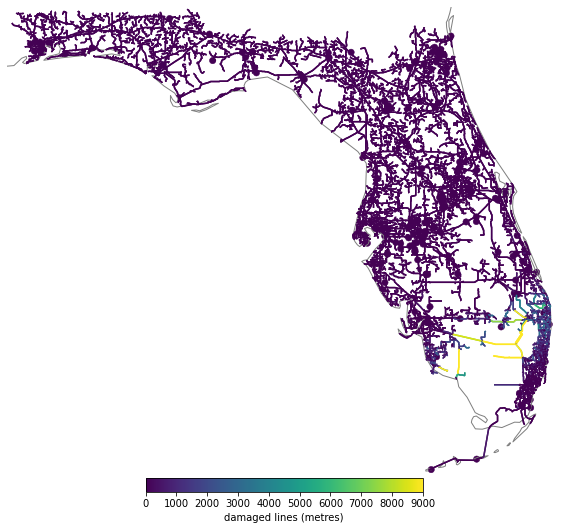

In [23]:
infra_impact_plot(gdf_lower_event, ci_type='power_line', save_path=None, event_name=lower_disr_event)

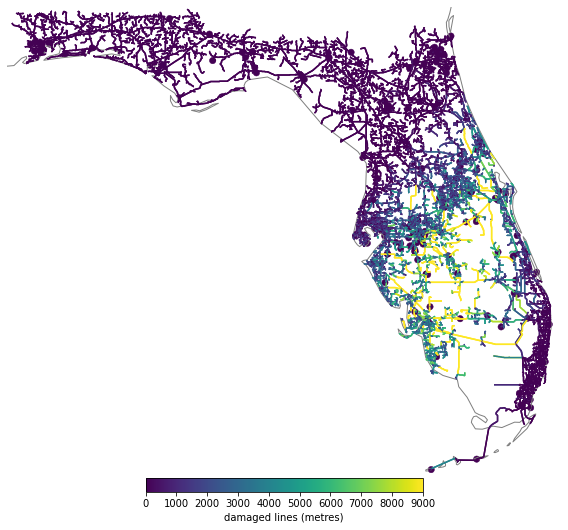

In [24]:
infra_impact_plot(gdf_higher_event, ci_type='power_line', save_path=None, event_name=lower_disr_event)

/scratch/tmp.22574263.evelynm/ipykernel_71479/3070338228.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


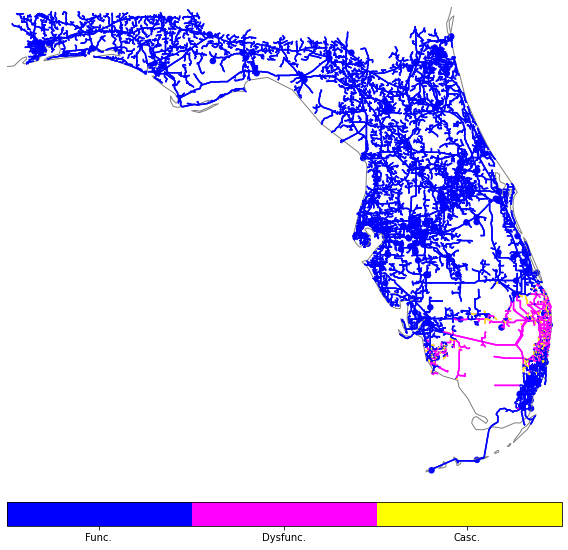

In [25]:
infra_func_plot(gdf_lower_event, ci_type='power_line', save_path=None, event_name=None)

/scratch/tmp.22574263.evelynm/ipykernel_71479/3070338228.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


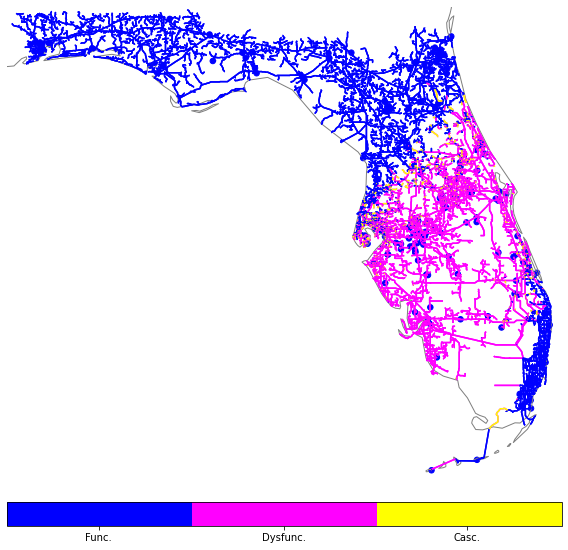

In [26]:
infra_func_plot(gdf_higher_event, ci_type='power_line', save_path=None, event_name=None)

/scratch/tmp.22574263.evelynm/ipykernel_71479/4169882256.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


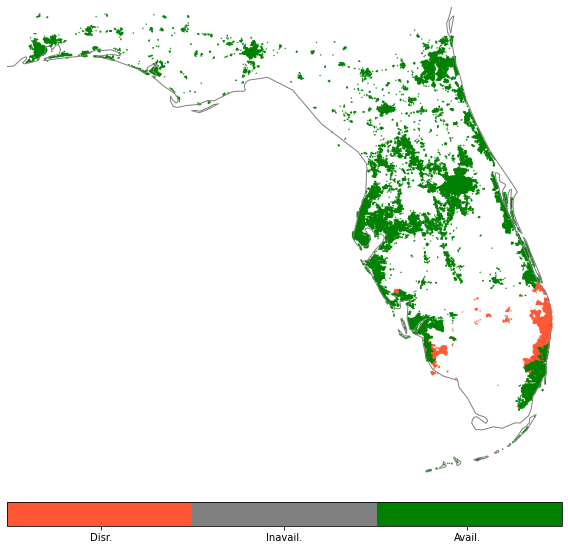

In [27]:
service_impact_plot(gdf_lower_event, service='actual_supply_power_line_people')

/scratch/tmp.22574263.evelynm/ipykernel_71479/4169882256.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


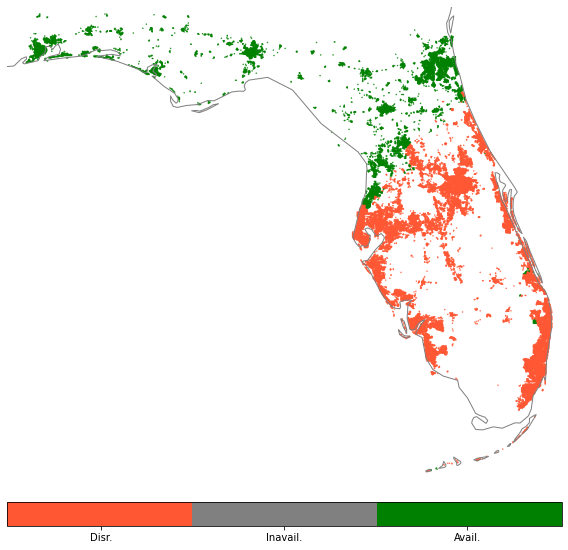

In [28]:
service_impact_plot(gdf_higher_event, service='actual_supply_power_line_people')